In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
from feateng import *
import matplotlib.pyplot as plt

In [3]:
files = list(Path('../data/talking_data/').iterdir())
files

[PosixPath('../data/talking_data/test.csv'),
 PosixPath('../data/talking_data/test.csv.zip'),
 PosixPath('../data/talking_data/train_sample.csv'),
 PosixPath('../data/talking_data/train_sample.csv.zip'),
 PosixPath('../data/talking_data/train.csv.zip'),
 PosixPath('../data/talking_data/train.csv')]

In [4]:
train = pd.read_csv(files[2])

In [5]:
train.head(2)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0


In [6]:
# convert to datetime
train.click_time = pd.to_datetime(train.click_time)

In [7]:
train['hour'] = train.click_time.dt.hour

In [8]:
train.sort_values(by="click_time", ascending=True, inplace=True)

In [9]:
train.reset_index(inplace=True, drop=True)

In [10]:
# train.head(2)

# # extract hour
# train['hour'] = train.click_time.dt.hour

# train.head(2)

# ip_device_counts = train.groupby('ip')['device'].apply(lambda x: x.nunique()).reset_index()

# ip_device_counts.head()

# device_change = ip_device_counts[ip_device_counts.device > 1]

# ip_device_counts.device.max()

# plt.hist(device_change.device)

# plt.hist(train.groupby("ip")["ip"].count())

In [19]:
train["random"] = np.random.randn(len(train))

In [28]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'hour', 'ip_device_os', 'app_channel', 'ip_channel',
       'ip_device_os_kfold_mean', 'ip_device_os_expanding_mean',
       'app_channel_kfold_mean', 'app_channel_expanding_mean', 'ip_kfold_mean',
       'ip_expanding_mean', 'app_kfold_mean', 'app_expanding_mean',
       'channel_kfold_mean', 'channel_expanding_mean', 'ip_channel_kfold_mean',
       'ip_channel_expanding_mean', 'random'],
      dtype='object')

In [56]:
train_data = train[:80000]
val_data = train[80000:90000]
test_data = train[90000:]

usecols = ['ip', 'app', 'device', 'os', 'channel',
       'hour', 'app_channel', 'ip_device_os_expanding_mean',
       'app_channel_kfold_mean', 'app_channel_expanding_mean', 'ip_kfold_mean',
       'ip_expanding_mean', 'app_kfold_mean', 'app_expanding_mean',
       'channel_kfold_mean', 'channel_expanding_mean', 'ip_channel_kfold_mean',
       'random']

trn_df = train_data[usecols] 
val_df = val_data[usecols]
test_df = test_data[usecols]

trn_y = train_data.is_attributed
val_y = val_data.is_attributed
test_y = test_data.is_attributed

### xgb

In [57]:
from xgb_learn.dataset import *
from xgb_learn.learner import *

In [58]:
md = XGBModelData(trn_df, val_df, trn_y, val_y)

In [59]:
dtrain, dval, evals = md.get_train_eval_ds()

In [60]:
xgb_learner = XGBLearner(dtrain, evals, True, 0.1, "binary:logistic", "auc")

In [61]:
xgb_learner.init_num_rounds, xgb_learner.init_early = 100, 10

In [62]:
xgb_learner.initialize()

Initialization Successful


In [63]:
xgb_learner.num_rounds

16

In [64]:
xgb_learner.random_search(100, verbose=True)

Found new best score 0.994161
Found new best score 0.994599
----------------------------------------
Best params and best iteration are found
----------------------------------------


In [65]:
xgb_learner.fit_best_model(dtrain)

In [78]:
# generalize
xgb_learner.best_iteration = xgb_learner.best_iteration*10
xgb_learner.best_params['eta'] = xgb_learner.best_params['eta']/10

In [81]:
xgb_learner.fit_best_model(dtrain)

In [79]:
xgb_learner.best_params

{'colsample_bylevel': 0.5646318906765148,
 'colsample_bytree': 0.2447481283438151,
 'eta': 0.01,
 'eval_metric': 'auc',
 'gamma': 2,
 'max_depth': 5,
 'min_child_weight': 42,
 'objective': 'binary:logistic',
 'seed': 20,
 'subsample': 0.6139158675405303}

In [80]:
xgb_learner.best_iteration

270

#### shap

In [82]:
import shap

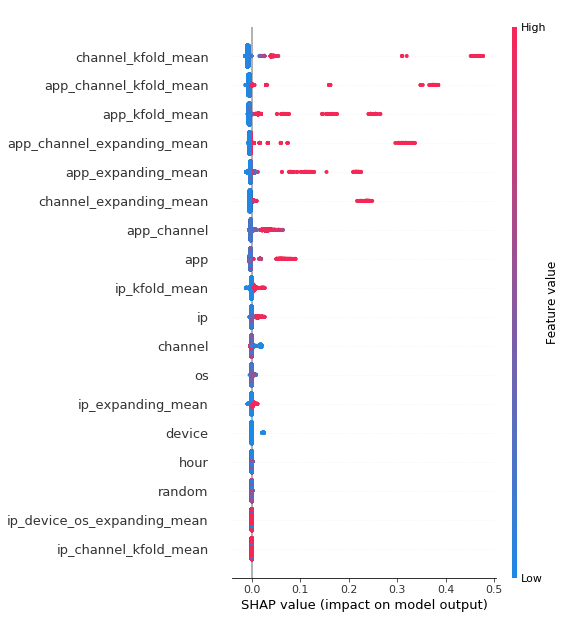

In [83]:
shap_values = shap.TreeExplainer(xgb_learner.best_model).shap_values(val_df.sample(10000, random_state=4))
shap.summary_plot(shap_values, val_df.sample(10000, random_state=4))

#### leaf preds

In [84]:
all_data = xgb.DMatrix(pd.concat([trn_df, val_df, test_df]))

In [85]:
xgb_leaf_preds = xgb_learner.predict(all_data, True)

In [86]:
xgb_leaf_preds_encoded = pd.get_dummies(pd.DataFrame(xgb_leaf_preds), columns=range(12))

In [87]:
xgb_leaf_preds_encoded.shape

(100000, 285)

#### actual preds

In [88]:
# predict on test
from sklearn.metrics import roc_auc_score
test_preds = xgb_learner.predict(xgb.DMatrix(test_df))

In [102]:
# expanding + kfold features with interactions best columns
roc_auc_score(test_y, test_preds)

0.9841533066132263

In [522]:
# interactions
roc_auc_score(test_y, test_preds)

0.9748697394789578

In [70]:
# expanding + kfold features with interactions
roc_auc_score(test_y, test_preds)

0.9824023046092184

In [121]:
# with random + all features
roc_auc_score(test_y, test_preds)

0.9816057114228457

In [135]:
# with random + bad features dropped
roc_auc_score(test_y, test_preds)

0.9852730460921845

In [167]:
# with random + bad features dropped + ip channel
roc_auc_score(test_y, test_preds)

0.9872745490981962

In [185]:
# with random + bad features dropped
roc_auc_score(test_y, test_preds)

0.9817034068136272

In [74]:
# with random + bad features dropped + time since
roc_auc_score(test_y, test_preds)

0.9718837675350702

In [89]:
# with random + bad features dropped + time since
roc_auc_score(test_y, test_preds)

0.9693912825651303

### lgb

In [92]:
from xgb_learn.dataset import *
from xgb_learn.learner import *

In [93]:
dtrain = lgb.Dataset(data=trn_df, label=trn_y)
dval = lgb.Dataset(data=val_df, label=val_y)

In [94]:
lgb_learner = LGBMLearner(dtrain, dval, True, 0.1, "binary", "auc", verbose_eval=False)

In [95]:
lgb_learner.initialize()

Initialization Successful


In [96]:
lgb_learner.num_rounds

49

In [97]:
lgb_learner.random_search(100, verbose=True)

Found new best score 0.9930265664160401
Found new best score 0.9940210526315789
Found new best score 0.994558395989975
----------------------------------------
Best params and best iteration are found
----------------------------------------


In [98]:
lgb_learner.params

{'feature_fraction': 0.8234105498240059,
 'learning_rate': 0.1,
 'max_bin': 937,
 'metric': 'auc',
 'min_child_samples': 76,
 'min_child_weight': 8,
 'min_split_gain': 5,
 'num_leaves': 60,
 'objective': 'binary',
 'seed': 20,
 'subsample': 0.8641238232117986,
 'verbose': 1}

In [99]:
lgb_learner.best_iteration

50

In [100]:
lgb_learner.fit_best_model(dtrain)

#### leaf preds

In [101]:
lgb_leaf_preds = lgb_learner.predict(pd.concat([trn_df, val_df, test_df]), True)

In [102]:
lgb_leaf_preds_encoded = pd.get_dummies(pd.DataFrame(lgb_leaf_preds), columns=range(7))

In [103]:
lgb_leaf_preds_encoded.shape

(100000, 113)

#### normal preds

In [104]:
test_preds = lgb_learner.predict(test_df)

In [504]:
# default
roc_auc_score(test_y, test_preds)

0.9809018036072144

In [562]:
# column interactions
roc_auc_score(test_y, test_preds)

0.9607640280561122

In [431]:
roc_auc_score(test_y, test_preds)

0.963371743486974

In [357]:
roc_auc_score(test_y, test_preds)

0.9466432865731462

In [105]:
roc_auc_score(test_y, test_preds)

0.9629859719438877

### logistic

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [250]:
leaf_trn_df = xgb_leaf_preds_encoded[:80000]
leaf_val_df = xgb_leaf_preds_encoded[80000:90000]
leaf_test_df = xgb_leaf_preds_encoded[90000:]

In [254]:
for c in [10**i for i in range(-6,6)]:
    lr = LogisticRegression(penalty='l2', dual=False, C=c, max_iter=100)
    lr.fit(leaf_trn_df, trn_y)
    preds = lr.predict_proba(leaf_val_df)
    score = roc_auc_score(val_y, preds[:, 1])
    print(c, score)

1e-06 0.9596270676691729
1e-05 0.9596230576441103
0.0001 0.9556531328320802
0.001 0.9568561403508772
0.01 0.9636090225563909
0.1 0.9699849624060151
1 0.9700651629072682
10 0.9750656641604009
100 0.9756190476190476
1000 0.9759117794486214
10000 0.9759358395989974
100000 0.9759438596491227


In [273]:
# test 
lr = LogisticRegression(penalty='l2', dual=False, C=1, max_iter=100)
lr.fit(leaf_trn_df, trn_y)
preds = lr.predict_proba(leaf_test_df)

In [274]:
score = roc_auc_score(test_y, preds[:, 1])
score

0.9648246492985972

### new features

In [10]:
# feature interactions
column_groups = [
    ['ip', 'device', 'os'],
    ['app', 'channel']
]

In [11]:
for columns in column_groups:
    new_column = '_'.join(columns)
    train[new_column] = ""

    for c in columns:
        train[new_column] += train[c].astype(str) + "_"
    
    val2idx = {val:i for i,val in enumerate(train[new_column].unique())}
    train[new_column] = train[new_column].map(val2idx)

In [12]:
def create_feat_interaction(data, columns):
    """
    Create Featuer Interactions Column
    
    data (pd.DataFrame): Input dataframe to create the new column
    columns (list): column names in list to combine
    """
    
    new_column = '_'.join(columns)
    data[new_column] = ""

    for c in columns:
        data[new_column] += data[c].astype(str) + "_"
    
    val2idx = {val:i for i,val in enumerate(data[new_column].unique())}
    data[new_column] = data[new_column].map(val2idx)
    return data

In [13]:
train = create_feat_interaction(train, ['ip', 'channel'])

In [14]:
# mean encode combinations
train_data = train[:80000] 
val_data = train[80000:90000]
test_data = train[90000:]

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
for col in ["ip_device_os", "app_channel", "ip", "app", "channel", "ip_channel"]:
    # train
    train_data = kfold_mean_encoding(train_data, col,
                                     col+"_kfold_mean", "is_attributed", seed=10, alpha=30)
    # train
    train_data = expanding_mean_encoding(train_data, col,
                                     col+"_expanding_mean", "is_attributed")
    
    
    # val
    val_data = mean_encoding_test(val_data, train_data, col,
                                    col+"_kfold_mean", "is_attributed")
    # val
    val_data = mean_encoding_test(val_data, train_data, col,
                                    col+"_expanding_mean", "is_attributed")
    
    
    # test
    test_data = mean_encoding_test(test_data, pd.concat([train_data, val_data]), col,
                                    col+"_kfold_mean", "is_attributed")
    # test
    test_data = mean_encoding_test(test_data, pd.concat([train_data, val_data]), col,
                                    col+"_expanding_mean", "is_attributed")

In [17]:
train = pd.concat([train_data, val_data, test_data])

In [18]:
train.head(2)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,ip_device_os,...,app_channel_kfold_mean,app_channel_expanding_mean,ip_kfold_mean,ip_expanding_mean,app_kfold_mean,app_expanding_mean,channel_kfold_mean,channel_expanding_mean,ip_channel_kfold_mean,ip_channel_expanding_mean
0,48646,12,1,19,178,2017-11-06 16:00:00,NaN,0,16,0,...,0.000031,0.001974,0.001896,0.001019,0.000006,0.002193,0.000028,0.002188,0.002133,0.000392
1,93836,12,1,30,328,2017-11-06 16:00:09,NaN,0,16,1,...,0.000081,0.001974,0.001796,0.001019,0.000123,0.000000,0.000081,0.002188,0.002210,0.000392


In [20]:
(train.click_time.max() - train.click_time.min()).seconds

86391

In [21]:
# time since last click
col, time, target = 'channel', 'click_time', "is_attributed"

train = time_since_flag(train, col, time, target, 1) # time since someone last clicked
train = time_since_flag(train, col, time, target, 0) # time since someone last didn't click